In [25]:
# Project Name: Shadow Removal

# Team: Anson Antony (002756978), Tarun Saxena (002979327)

# Testing of the Model

In [1]:
!pip install tensorflow
!pip install matplotlib
!pip install tensorflow_addons
!pip install keras

  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/67/5f/6ba8ccef6305f2fff166c8bec73e583072065dcf522dbee5077972d0b799/tensorflow-2.13.1-cp38-cp38-macosx_12_0_arm64.whl.metadata
INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.
  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/b9/ab/a04186eaaeaa1969b4d81dc74aa440f98c8eb7c92b0cd33ceda37b70d46e/tensorflow-2.13.0-cp38-cp38-macosx_12_0_arm64.whl.metadata
Using cached tensorflow-2.13.0-cp38-cp38-macosx_12_0_arm64.whl (1.9 kB)
  Obtaining dependency information for tensorflow_addons from https://files.pythonhosted.org/packages/9d/ce/e6705610d63bd892c11e9cec0a2f9f6367e7e3e83cc6819f7611bb7c699a/tensorflow_addons-0.21.0-cp38-cp38-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.9/11.9 MB 28.5 MB/s eta 0:00:0000:0100:01


In [2]:
# Import required packages
import os
import sys
import datetime
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

from os import listdir
from keras.models import load_model
from tensorflow_addons.layers import InstanceNormalization
from tensorflow.keras.preprocessing import image


/Users/ansonantony/miniforge3/envs/tensorflow/lib/python3.8/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [22]:
# Select one of them:
model_path_pair = './output/pretrained_models/pair/generator_free_model_001000.h5'
model_path_unpair = './output/pretrained_models/unpair/generator_free_model_001000.h5'

dataset_path = './datasets/ISTD/'
output_path = './output/'

In [4]:
# load images in a directory into memory
# dataset_size: set how many images will be loaded; if None, all images will be loaded
def load_images(path, size, dataset_size=None):
    data_list = list()
    for filename in listdir(path):
        
        try:
            pixels = image.load_img(path + filename, target_size=size)
        except:
            print(">> Encountered non-image file, skipping ", filename)
            continue # some files like .DS_Store may be caught
        
        # convert to numpy array
        pixels = image.img_to_array(pixels)
        # store
        data_list.append(pixels)
        if dataset_size:
            dataset_size -= 1
            if dataset_size == 0:
                break
    return np.asarray(data_list)


In [5]:
# Select random samples given a dataset and number of samples 
# If idx is set, select corresponding samples from given indices
# E.g. idx=[0,3,5] returns the instances at 0th, 3rd, and 5th locations
def select_sample(dataset, n_samples=5, idx=None):
    # choose random instances
    if idx is None:
        idx = np.random.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    x = dataset[idx]
    return x, idx

In [6]:
def plot_model_output(random_samples_free, random_samples_shadow, output_pair, output_unpair, path_output):
    num_samples, _, _, _ = random_samples_free.shape
    images = np.concatenate((random_samples_shadow, random_samples_free, output_pair, output_unpair), axis=0)
    images = ((images + 1) / 2.0) * 255.

    #title = 'Shadow\nFree-Original\nFree-Generated'

    for j in range(4):
        for i in range(j*num_samples, (j+1)*num_samples):
            plt.subplot(4, num_samples, i+1)
            plt.imshow(images[i].astype(np.uint8))
            plt.axis('off')
    #plt.suptitle(title)

    # save plot to file
    foldername = 'results'
    path_results = os.path.join(path_output, foldername)
    if foldername not in os.listdir(path_output):
        os.mkdir(path_results)
    filename = 'results %s.png' % datetime.datetime.now()
    save_path = os.path.join(path_results, filename)
    plt.savefig(save_path)
    #plt.close()

In [7]:
def plot_USR(random_samples_shadow, model_output, path_output):
    num_samples, _, _, _ = random_samples_shadow.shape
    images = np.concatenate((random_samples_shadow, model_output), axis=0)
    images = ((images + 1) / 2.0) * 255.

    for j in range(2):
        for i in range(j*num_samples, (j+1)*num_samples):
            plt.subplot(2, num_samples, i+1)
            plt.imshow(images[i].astype(np.uint8))
            plt.axis('off')

    # save plot to file
    foldername = 'results'
    path_results = os.path.join(path_output, foldername)
    if foldername not in os.listdir(path_output):
        os.mkdir(path_results)
    filename = 'results_usr_%s.png' % datetime.datetime.now()
    save_path = os.path.join(path_results, filename)
    plt.savefig(save_path)
    #plt.close()

In [8]:
def plot_model_output(random_samples_free, random_samples_shadow, model_output, path_output):
    num_samples, _, _, _ = random_samples_free.shape
    images = np.concatenate((random_samples_shadow, random_samples_free, model_output), axis=0)
    images = ((images + 1) / 2.0) * 255.

    title = 'Shadow\nFree-Original\nFree-Generated'

    for j in range(3):
        for i in range(j*num_samples, (j+1)*num_samples):
            plt.subplot(3, num_samples, i+1)
            plt.imshow(images[i].astype(np.uint8))
            plt.axis('off')
    #plt.suptitle(title)

    # save plot to file
    foldername = 'results'
    path_results = os.path.join(path_output, foldername)
    if foldername not in os.listdir(path_output):
        os.mkdir(path_results)
    filename = 'results %s.png' % datetime.datetime.now()
    save_path = os.path.join(path_results, filename)
    plt.savefig(save_path)
    #plt.close()

In [10]:
# Load the dataset images (test)
data_shadow = load_images(dataset_path + 'test/test_A/', size=(512, 512)) # 'A' is the shadow images (X)
data_free = load_images(dataset_path + 'test/test_C/', size=(512, 512))   # 'C' is the shadow-free images (Y)

# Preprocess the images from [0,255] range to the model range [-1, 1] (see original paper)
data_shadow = (data_shadow/255.) * 2.0 - 1.0
data_free = (data_free/255.) * 2.0 - 1.0

print(">> Loaded ",data_free.shape," shadow-free and ",data_shadow.shape, "shadow images")

>> Loaded  (540, 512, 512, 3)  shadow-free and  (540, 512, 512, 3) shadow images


In [12]:
# Load the pre-trained model for testing 
# The generator that frees the shadow is loaded to remove the shadows in the test cases

gen_f_pair = load_model(model_path_pair,custom_objects={'InstanceNormalization':InstanceNormalization})
gen_f_unpair = load_model(model_path_unpair,custom_objects={'InstanceNormalization':InstanceNormalization})


2023-10-13 18:53:01.862503: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-10-13 18:53:01.862627: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-10-13 18:53:01.862636: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-10-13 18:53:01.863281: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-13 18:53:01.863751: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-10-13 18:53:01.898119: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x11ab19d30 initialized for platform Host (this does not guarantee that XLA will be used). D

## Plot the results
You can run the cell below repeatedly to plot different samples from the test dataset

Selected indices:  [33, 417, 162, 1, 2]
Top: Original shadow images
Middle: Original shadow-free images
Bottom1: Generated shadow-free images (paired data)


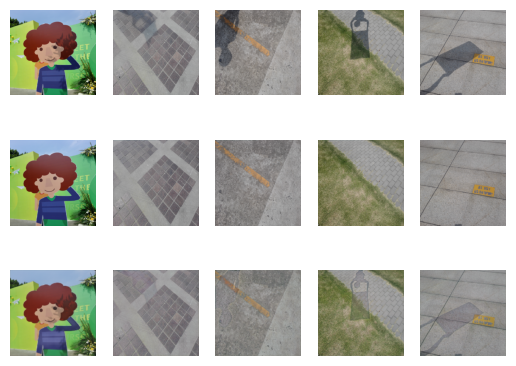

In [15]:
# Select some of the samples 
# Performs good on :17, 181, 183, 190, 519, 256, 458, 462, 461, 78, 33, 417, 162
# Performs worse on: 173, 372, 533, 366, 481, 229, 399
random_samples_shadow, idx = select_sample(data_shadow, idx=[33, 417, 162, 1,2]) 
random_samples_free = data_free[idx]

# Obtain the model output for shadow images
model_output_pair = gen_f_pair(random_samples_shadow).numpy()
model_output_unpair = gen_f_unpair(random_samples_shadow).numpy()

# Plot the original shadow and shadow-free images with the generated shadow-free image
plot_model_output(random_samples_free, random_samples_shadow, model_output_pair, output_path)

print("Selected indices: ", idx)
print("Top: Original shadow images")
print("Middle: Original shadow-free images")
print("Bottom1: Generated shadow-free images (paired data)")

Selected indices:  [33, 417, 162, 1, 2]
Top: Original shadow images
Middle: Original shadow-free images
Bottom1: Generated shadow-free images (unpaired data)


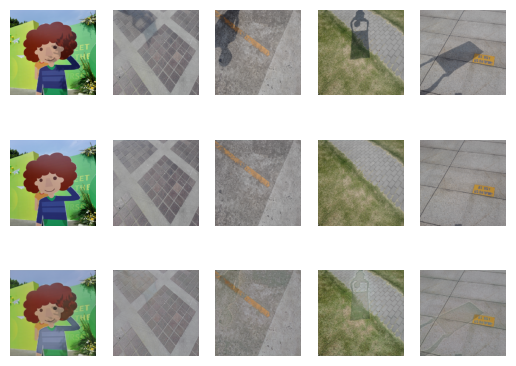

In [16]:
# Select some of the samples 
# Performs good on :17, 181, 183, 190, 519, 256, 458, 462, 461, 78, 33, 417, 162
# Performs worse on: 173, 372, 533, 366, 481, 229, 399
random_samples_shadow, idx = select_sample(data_shadow, idx=[33, 417, 162, 1,2]) 
random_samples_free = data_free[idx]

# Obtain the model output for shadow images
model_output_pair = gen_f_pair(random_samples_shadow).numpy()
model_output_unpair = gen_f_unpair(random_samples_shadow).numpy()

# Plot the original shadow and shadow-free images with the generated shadow-free image
plot_model_output(random_samples_free, random_samples_shadow, model_output_unpair, output_path)

print("Selected indices: ", idx)
print("Top: Original shadow images")
print("Middle: Original shadow-free images")
print("Bottom1: Generated shadow-free images (unpaired data)")

# Quantitative Analysis

Compare the regenerated image results with original image.

In [20]:
# Convert images from range [-1,1] to [0,1]
a = generated_free = (model_output_pair+1)/2.
b = original_free = (random_samples_free+1)/2.

# Measure Peak Signal to Noise Ratio (PSNR)
psnr = tf.reduce_mean(tf.image.psnr(a, b, 255.)).numpy()

# Measure Root Mean Squared Error (RMSE)
rmse = tf.sqrt(tf.reduce_mean(tf.square(a-b))).numpy()

print("PSNR: ", psnr)
print("RMSE: ", rmse)

PSNR:  75.58538
RMSE:  0.045501284


In [21]:
# Convert images from range [-1,1] to [0,1]
a = generated_free = (model_output_unpair+1)/2.
b = original_free = (random_samples_free+1)/2.

# Measure Peak Signal to Noise Ratio (PSNR)
psnr = tf.reduce_mean(tf.image.psnr(a, b, 255.)).numpy()

# Measure Root Mean Squared Error (RMSE)
rmse = tf.sqrt(tf.reduce_mean(tf.square(a-b))).numpy()

print("PSNR: ", psnr)
print("RMSE: ", rmse)

PSNR:  74.33581
RMSE:  0.05785122
